In [ ]:
!pip install torchmetrics

import time
import timm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import Accuracy
import os
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Modelin beklediği boyut
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Veri kümesini yükle
data_dir = "/content/drive/MyDrive/Projem"
dataset = ImageFolder(data_dir, transform=transform)

# Veri kümesini sınıf bazında böl
train_indices, test_indices = train_test_split(
    range(len(dataset)), test_size=0.2, stratify=dataset.targets, random_state=42
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Train ve test loader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LeViT-128S Modeli
model = timm.create_model('levit_128s', pretrained=True, num_classes=len(dataset.classes))

# Checkpoint kaydetme fonksiyonu
def save_checkpoint(model, optimizer, epoch, train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'y_true': y_true,
        'y_pred': y_pred,
    }, checkpoint_path)

# Checkpoint yükleme fonksiyonu
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_loss = checkpoint['train_loss']
        test_loss = checkpoint['test_loss']
        train_accuracy = checkpoint['train_accuracy']
        test_accuracy = checkpoint['test_accuracy']
        y_true = checkpoint['y_true']
        y_pred = checkpoint['y_pred']
        print(f"Checkpoint loaded, starting from epoch {epoch}.")
        return model, optimizer, epoch, train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred
    else:
        print("No checkpoint found, starting from scratch.")
        return model, optimizer, 0, [], [], [], [], [], []

# Eğitim fonksiyonu
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-4, checkpoint_dir="/content/drive/My Drive/Projem/LeVit-checkpoints"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)

    # Checkpoint klasörünü oluştur
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Eğitim ve test kayıpları, doğruluklar
    train_loss, test_loss, train_accuracy, test_accuracy = [], [], [], []
    y_true, y_pred = [], []

    # Checkpoint'ten durumu yükle
    checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
    model, optimizer, start_epoch, prev_train_loss, prev_test_loss, prev_train_accuracy, prev_test_accuracy, prev_y_true, prev_y_pred = load_checkpoint(
        model, optimizer, checkpoint_path
    )

    start_time = time.time()

    for epoch in range(start_epoch, epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Training accuracy
            preds = torch.argmax(outputs, dim=1)
            train_accuracy.append(accuracy(preds, labels).item())

        train_loss.append(epoch_loss / len(train_loader))

        model.eval()
        epoch_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

                # Testing accuracy
                preds = torch.argmax(outputs, dim=1)
                test_accuracy.append(accuracy(preds, labels).item())

                # Collect true and predicted labels for metrics
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        test_loss.append(epoch_loss / len(test_loader))

        # Model checkpoint kaydetme
        save_checkpoint(model, optimizer, epoch + 1, train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred, checkpoint_path)

        # Epoch tamamlandığında geçen süreyi yazdırma
        epoch_time = time.time() - epoch_start_time
        remaining_time = (epochs - (epoch + 1)) * epoch_time
        print(f"Epoch {epoch+1}/{epochs} tamamlandı - Geçen Süre: {epoch_time:.2f} saniye - Kalan Süre: {remaining_time:.2f} saniye")

    end_time = time.time()

    return train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred, start_time, end_time

# Eğitimi Başlat
print("LeViT-128S Modeli Eğitiliyor...")
train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred, start_time, end_time = train_model(
    model, train_loader, test_loader, epochs=10
)

training_time = end_time - start_time

print(f"LeViT-128S Modeli Eğitim Tamamlandı! Eğitim Süresi: {training_time} saniye")
print(f"Eğitim Kaybı: {train_loss[-1]}, Test Kaybı: {test_loss[-1]}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LeViT-128S Modeli Eğitiliyor...
No checkpoint found, starting from scratch.
Epoch 1/10 tamamlandı - Geçen Süre: 4527.01 saniye - Kalan Süre: 40743.06 saniye
Epoch 2/10 tamamlandı - Geçen Süre: 165.40 saniye - Kalan Süre: 1323.22 saniye
Epoch 3/10 tamamlandı - Geçen Süre: 165.58 saniye - Kalan Süre: 1159.09 saniye
Epoch 4/10 tamamlandı - Geçen Süre: 164.39 saniye - Kalan Süre: 986.33 saniye
Epoch 5/10 tamamlandı - Geçen Süre: 164.82 saniye - Kalan Süre: 824.08 saniye
Epoch 6/10 tamamlandı - Geçen Süre: 165.01 saniye - Kalan Süre: 660.04 saniye
Epoch 7/10 tamamlandı - Geçen Süre: 164.74 saniye - Kalan Süre: 494.22 saniye
Epoch 8/10 tamamlandı - Geçen Süre: 165.27 saniye - Kalan Süre: 330.54 saniye
Epoch 9/10 tamamlandı - Geçen Süre: 165.30 saniye - Kalan Süre: 165.30 saniye
Epoch 10/10 tamamlandı - Geçen Süre: 165.60 saniye - Kalan Süre: 0.00 saniye
LeViT-128S 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-6d6da66793fc>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


Checkpoint yüklendi.
Son Eğitim Kaybı: 0.11940586695730773
Son Test Kaybı: 0.8593379036027785
Son Eğitim Doğruluğu: 1.0
Son Test Doğruluğu: 0.8125
Sınıflandırma Raporu:
                precision    recall  f1-score   support

       Cubism       0.78      0.78      0.78     11000
Expressionism       0.75      0.74      0.74     11760
Impressionism       0.79      0.81      0.80     12780
      Realism       0.71      0.72      0.71      9180
   Surrealism       0.75      0.72      0.73     10000

     accuracy                           0.76     54720
    macro avg       0.75      0.75      0.75     54720
 weighted avg       0.76      0.76      0.76     54720



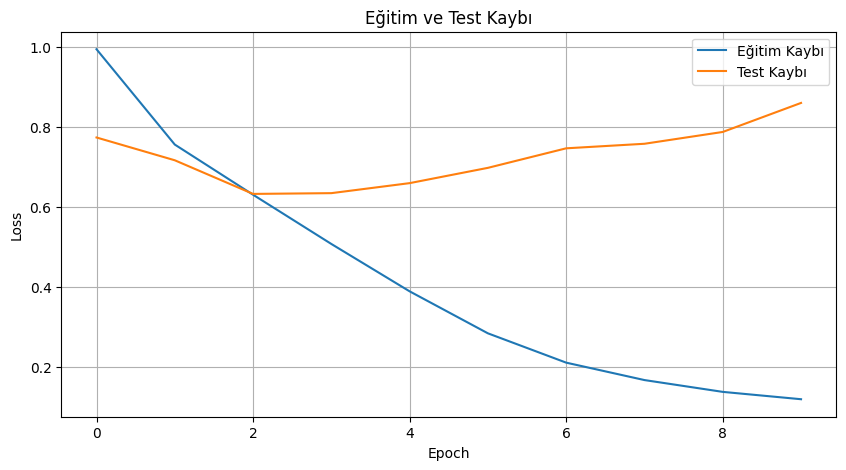

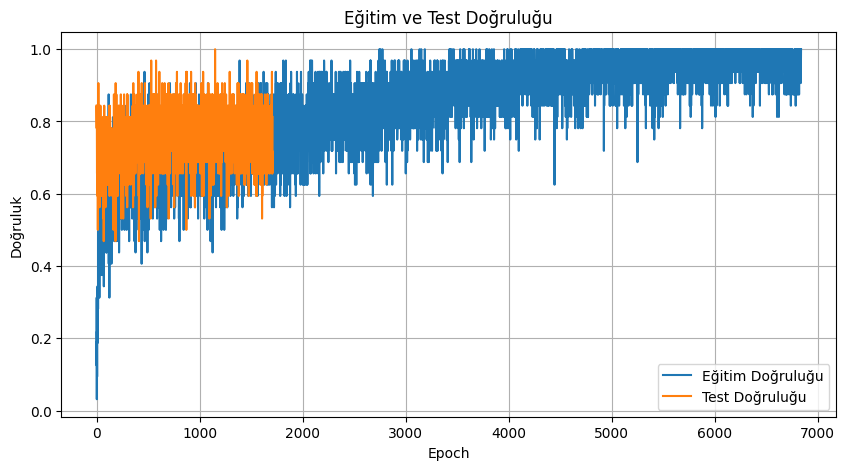

y_pred sınıf indekslerini içeriyor, olasılıklara dönüştürülüyor.


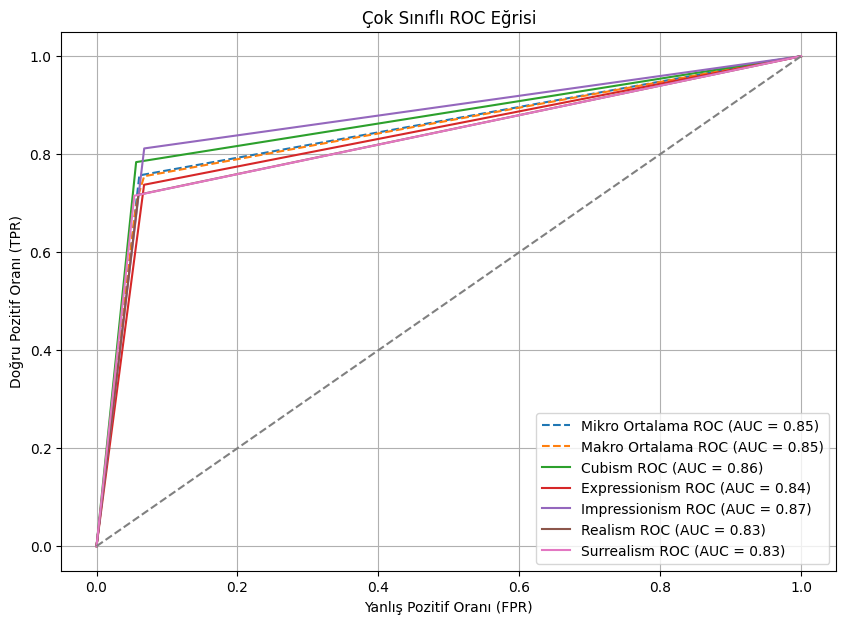

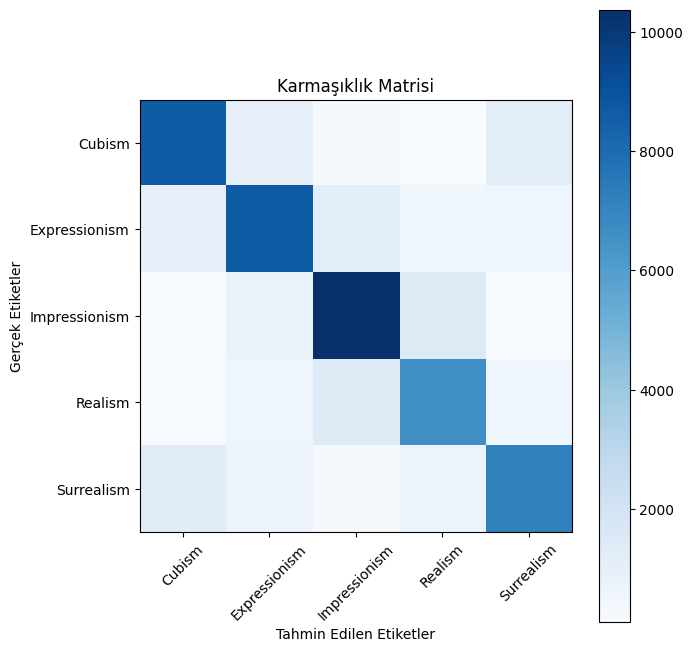

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np

# Google Drive'ı bağla
drive.mount('/content/drive')

# Checkpoint yükleme fonksiyonu
def load_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        train_loss = checkpoint['train_loss']
        test_loss = checkpoint['test_loss']
        train_accuracy = checkpoint['train_accuracy']
        test_accuracy = checkpoint['test_accuracy']
        y_true = checkpoint['y_true']
        y_pred = checkpoint['y_pred']
        print("Checkpoint yüklendi.")
        return train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred
    else:
        print("Checkpoint bulunamadı.")
        return [], [], [], [], [], []

# Grafik oluşturma fonksiyonu
def plot_graphs(train_loss, test_loss, train_accuracy, test_accuracy):
    # Kaybı grafik
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_loss)), train_loss, label='Eğitim Kaybı')
    plt.plot(range(len(test_loss)), test_loss, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('/content/drive/My Drive/MODELLER-YazLab/LeVit/loss_graph_2.png')
    plt.show()

    # Doğruluğu grafik
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_accuracy)), train_accuracy, label='Eğitim Doğruluğu')
    plt.plot(range(len(test_accuracy)), test_accuracy, label='Test Doğruluğu')
    plt.title('Eğitim ve Test Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid()
    plt.savefig('/content/drive/My Drive/MODELLER-YazLab/LeVit/accuracy_graph_2.png')
    plt.show()

# Çok sınıflı ROC eğrisi

def plot_multiclass_roc(y_true, y_pred, classes):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Eğer y_pred olasılık yerine sınıf indekslerini içeriyorsa, one-hot encode yap.
    if y_pred.ndim == 1 or y_pred.shape[1] != len(classes):
        print("y_pred sınıf indekslerini içeriyor, olasılıklara dönüştürülüyor.")
        from sklearn.preprocessing import label_binarize
        y_pred_one_hot = label_binarize(y_pred, classes=range(len(classes)))
    else:
        y_pred_one_hot = y_pred

    # y_true'yu binarize et
    from sklearn.preprocessing import label_binarize
    y_true_binarized = label_binarize(y_true, classes=range(len(classes)))

    # Her sınıf için ROC eğrisi
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_one_hot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Mikro ve makro ROC eğrisi
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_one_hot.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(classes)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC eğrisi
    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Mikro Ortalama ROC (AUC = {roc_auc["micro"]:.2f})', linestyle='--')
    plt.plot(fpr["macro"], tpr["macro"], label=f'Makro Ortalama ROC (AUC = {roc_auc["macro"]:.2f})', linestyle='--')

    for i, class_name in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_name} ROC (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Çok Sınıflı ROC Eğrisi')
    plt.xlabel('Yanlış Pozitif Oranı (FPR)')
    plt.ylabel('Doğru Pozitif Oranı (TPR)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig('/content/drive/My Drive/MODELLER-YazLab/LeVit/multiclass_roc_curve_2.png')
    plt.show()

# Karmaşıklık Matrisi

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Karmaşıklık Matrisi')
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Tahmin Edilen Etiketler')
    plt.ylabel('Gerçek Etiketler')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/MODELLER-YazLab/LeVit/confusion_matrix_2.png')
    plt.show()

# Sonuçları yazdırma fonksiyonu
def print_results(train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred, classes):
    print(f"Son Eğitim Kaybı: {train_loss[-1] if train_loss else 'Veri yok'}")
    print(f"Son Test Kaybı: {test_loss[-1] if test_loss else 'Veri yok'}")
    print(f"Son Eğitim Doğruluğu: {train_accuracy[-1] if train_accuracy else 'Veri yok'}")
    print(f"Son Test Doğruluğu: {test_accuracy[-1] if test_accuracy else 'Veri yok'}")

    # y_true ve y_pred boşsa sınıflandırma raporunu yazdırma
    if y_true and y_pred:
        report = classification_report(y_true, y_pred, target_names=classes)
        print("Sınıflandırma Raporu:\n", report)
    else:
        print("y_true ve y_pred verileri mevcut değil, sınıflandırma raporu oluşturulamadı.")

# Checkpoint yolunu belirt
checkpoint_path = "/content/drive/My Drive/MODELLER-YazLab/LeVit/LeVit-checkpoints/latest_checkpoint.pth"

# Checkpoint'i yükle
train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred = load_checkpoint(checkpoint_path)

# Sonuçları yazdır
classes = ['Cubism', 'Expressionism', 'Impressionism', 'Realism', 'Surrealism']
print_results(train_loss, test_loss, train_accuracy, test_accuracy, y_true, y_pred, classes)

# Grafik oluştur
plot_graphs(train_loss, test_loss, train_accuracy, test_accuracy)

# ROC eğrisi ve karmaşıklık matrisini çiz
if y_true and y_pred:
    plot_multiclass_roc(y_true, y_pred, classes=classes)
    plot_confusion_matrix(y_true, y_pred, classes=classes)
else:
    print("y_true ve y_pred verileri mevcut olmadığı için ROC ve karmaşıklık matrisi çizilemedi.")
